In [201]:
import numpy as np
import pandas as pd
import dill

# Introduction

**Summary of original goals.** The original goals of this capstone project were to determine how the patent portfolio of a particular company could be expected to change through: (a) transfers of patent assets to or from other owners; and (b) the granting of new patents following successful patent applications. Preliminary analyses have since shown that neither of those goals can be achieved in light of the informational constraints inherent in the research datasets released by the United States Patent and Trademark Offices ("USPTO"). 

**Non-feasibility of original goals.** Goal (a) effectively consists of predicting when future transactions involving patent assets will occur. Leading indicators of such transactions, however, are almost nonexistent in publicly available records. With virtually no information to analyze, it was not feasible even to begin building a machine-learning model to achieve goal (a). The focus of the capstone project consequently shifted to goal (b), which has proven more tractable in light of the available data. Goal (b), however, has nonetheless been modified to remedy certain deficiencies. As originally conceived, goal (b) consisted of predicting the ultimate outcome of a patent application—i.e., whether or not the application would result in the issuance of a U.S. patent. Preliminarly analyses, however, revealed serious practical obstacles to making such predictions. Multiple preliminary models could "achieve" an accuracy rate of only 50% in making those predictions—which is functionally identical to guessing. In retrospect, this difficulty should have been unsurprising. By definition, nothing is known about the legal merits of an invention when an application is newly filed. This fundamental lack of information cannot be overcome through a clever selection of machine-learning techniques. Without sufficient information on which to train, no model can give sensible predictions.

**Modified focus on patent examination rulings.** It then became evident that goal (b) could be made more tractable by focusing on individual rulings _within_ the examination process of a patent application rather than the outcome of the examination overall. Because the research datasets contain relatively granular information about those rulings, it seemed feasible to predict, given the current state of an application: (aa) what the next event in the examination process is likely to be; and (bb) how much time can be expected to elapse before that event occurs. As shown in the remainder of this notebook, this approach to forecasting examination events has proven tractable.

# Overview of Research Datasets

The research datasets are effectively "event timelines" of millions of patent applications, which collectively span decades of the USPTO's operations. The earliest applications in the datasets were filed in the 1940s, and the most recent applications were filed in 2021. For each patent application, the dataset gives: (a) identifying information recorded by the USPTO upon filing, including the application number, the filing date, and the invention title; and (b) the date and type of each event that occurred during the examination of the application; and (c) internal bureaucratic details, such as the name of the relevant patent examiner and the technology department (known as an "art unit") to which the application is assigned for processing. The USPTO has internally assigned each examination event an "event code" according to the legal or practical significant of the event. Rulings rejecting an invention as non-patentable, for example, are designated by the event code `CTNF` or `CTFR`. Rulings confirming patentability are given the event code `CNOA`. The termination of an unsuccessful application is identified by the event code `ABN` and others. These event listings form the core of the machine-learning models presented herein.

For practical expediency, the research datasets were filtered by date range and event code prior to use in this capstone project. With respect to date ranges, applications with filing dates between January 1, 2015, and December 31, 2017, were designated as training data, and applications filed in 2018 (i.e., with filing dates between January 1, 2018, and December 31, 2018) were designated as testing data. Since hundreds of thousands of patent applications are filed in the USPTO each year, the aforementioned three years' worth of application records is more than enough to give a representative picture of the examination process. This date range is recent enough to avoid various data-quality issues affecting older applications yet old enough to ensure that each included application has a well-developed examination record. Because a "typical" patent examination can be expected to last for three years, it is reasonable to assumed that the vast majority of the applications included the aforementioned date ranges have completed their examination processes. With respect to event codes, only events associated `CTNF`, `CTFR`, and other legally significant events are included. Because these legally significant events account for perhaps 20% of all the events recorded in the datasets, isolating them in advance results in significant storage savings.

On a technological level, the research datasets consist of multple CSV-format files. The contents of those files loaded into a MariaDB database, which was then queried from within Jupyter Notebook to produce the datasets called `raw_training_data` and `raw_testing_data` below. Those datasets are the starting point for the machine-learning models presented herein.

# Raw Data

As shown below, `raw_training_data` and `raw_testing_data` are Pandas dataframes containing the examination-related information described in the preceding sections of this notebook.

In [202]:
with open('training_data', 'rb') as dill_file:
    raw_training_data = dill.load(dill_file)

In [203]:
with open('test_data', 'rb') as dill_file:
    raw_testing_data = dill.load(dill_file)

In [204]:
raw_training_data.head()

,application_number,examiner_art_unit,filing_date,event_code,event_date,patent_number,patent_issue_date,invention_title,examiner_full_name,examiner_id,examiner_name_first,examiner_name_last,examiner_name_middle
0,11913160,1616,2015-11-02,CTRS,2016-02-23,,None,Compositions and Methods for Treating Microorg...,"LIU, SUE XU",None,None,None,None
1,11913160,1616,2015-11-02,CTNF,2018-10-29,,None,Compositions and Methods for Treating Microorg...,"LIU, SUE XU",None,None,None,None
2,12095695,3752,2017-01-03,CTNF,2013-10-04,9604242,2017-03-28,VOLATILE LIQUID DROPLET DISPENSER DEVICE,"ZHOU, QINGZHANG",None,None,None,None
3,12095695,3752,2017-01-03,CTNF,2015-01-12,9604242,2017-03-28,VOLATILE LIQUID DROPLET DISPENSER DEVICE,"ZHOU, QINGZHANG",None,None,None,None
4,12095695,3752,2017-01-03,CTFR,2015-07-01,9604242,2017-03-28,VOLATILE LIQUID DROPLET DISPENSER DEVICE,"ZHOU, QINGZHANG",None,None,None,None


In [205]:
raw_testing_data.head()

,application_number,examiner_art_unit,filing_date,event_code,event_date,patent_number,patent_issue_date,invention_title,examiner_full_name,examiner_id,examiner_name_first,examiner_name_last,examiner_name_middle
0,13695639,2116,2018-01-08,CTNF,2019-01-11,10519814,2019-12-31,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY",None,None,None,None
1,13695639,2116,2018-01-08,CTNF,2019-03-05,10519814,2019-12-31,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY",None,None,None,None
2,13695639,2116,2018-01-08,A.NA,2019-11-15,10519814,2019-12-31,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY",None,None,None,None
3,13817165,3763,2018-02-19,CTNF,2015-04-16,9950112,2018-04-24,Intelligent Drug and/or Fluid Delivery System ...,"HALL, DEANNA K",None,None,None,None
4,13817165,3763,2018-02-19,CTFR,2015-11-28,9950112,2018-04-24,Intelligent Drug and/or Fluid Delivery System ...,"HALL, DEANNA K",None,None,None,None


# Initial Processing with `get_event_data`

The `get_event_data` function below applies several important transformations to `raw_training_data` and `raw_testing_data`. First, `get_event_data` performs some basic feature engineering to produce columns that state: (a) how long an application has been pending as of a given event; and (b) how much time elapses between that event and the following event. The `get_event_data` function also performs preliminary cleanup, including filtering out invalid application numbers and art-unit numbers.

In [206]:
def get_event_data(raw_data):
    event_data = pd.DataFrame({
        'event_app_num': raw_data['application_number'],
        'event_code': raw_data['event_code'],
        'event_date': raw_data['event_date'],
        'next_event_app_num': raw_data['application_number'].shift(-1),
        'next_event_code': raw_data['event_code'].shift(-1),
        'next_event_date': raw_data['event_date'].shift(-1),
        'examiner_art_unit': pd.to_numeric(raw_data['examiner_art_unit'], errors='coerce'),
        'pendency_time': (raw_data['event_date'] - raw_data['filing_date']).dt.days,
        'invention_title': raw_data['invention_title'],
        'examiner_full_name': raw_data['examiner_full_name']
    })
    event_data = event_data.assign(
        wait_time=(event_data['next_event_date'] - event_data['event_date']).dt.days
    )
    event_data = event_data[
        (event_data['event_app_num'] == event_data['next_event_app_num']) & 
        (event_data['pendency_time'] > 0) &
        (event_data['event_app_num'].str[:2] != '29') &
        (event_data['event_app_num'].str[:2] != '35') &
        (event_data['event_app_num'].str[:2] != '62') &
        (event_data['event_app_num'].str[:2] != '90') &
        (event_data['event_app_num'].str[:2] != '96') &
        (pd.notna(event_data['examiner_art_unit']))
    ]
    return event_data

In [207]:
training_event_data = get_event_data(raw_training_data)

In [208]:
training_event_data.head()

,event_app_num,event_code,event_date,next_event_app_num,next_event_code,next_event_date,examiner_art_unit,pendency_time,invention_title,examiner_full_name,wait_time
0,11913160,CTRS,2016-02-23,11913160,CTNF,2018-10-29,1616.0,113,Compositions and Methods for Treating Microorg...,"LIU, SUE XU",979.0
5,12524548,CTNF,2017-07-05,12524548,CTFR,2018-02-12,3771.0,576,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A",222.0
6,12524548,CTFR,2018-02-12,12524548,CTNF,2018-11-27,3771.0,798,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A",288.0
7,12524548,CTNF,2018-11-27,12524548,CTFR,2019-06-26,3771.0,1086,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A",211.0
15,12935772,CTNF,2016-03-14,12935772,CTNF,2016-10-18,2877.0,431,COMPACT SPECTROMETER FOR TWO-DIMENSIONAL SAMPLING,"DECENZO, SHAWN H",218.0


In [209]:
testing_event_data = get_event_data(raw_testing_data)

In [210]:
testing_event_data.head()

,event_app_num,event_code,event_date,next_event_app_num,next_event_code,next_event_date,examiner_art_unit,pendency_time,invention_title,examiner_full_name,wait_time
0,13695639,CTNF,2019-01-11,13695639,CTNF,2019-03-05,2116.0,368,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY",53.0
1,13695639,CTNF,2019-03-05,13695639,A.NA,2019-11-15,2116.0,421,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY",255.0
9,14441499,CTNF,2019-09-28,14441499,A.NA,2020-03-20,2886.0,323,METHOD FOR MONITORING LINEAR DIMENSIONS OF THR...,"AMARA, MOHAMED K",174.0
11,14764986,CTRS,2020-02-02,14764986,CTNF,2020-03-31,1782.0,658,"BLACK MATRIX, METHOD FOR MANUFACTURING THE SAM...","HON, SOW FUN",58.0
12,14764986,CTNF,2020-03-31,14764986,CTFR,2020-09-11,1782.0,716,"BLACK MATRIX, METHOD FOR MANUFACTURING THE SAM...","HON, SOW FUN",164.0


# Generating Features and Labels

The `get_features_and_labels` function takes the output of `get_event_data` as input and produces dataframes containing features and series containing labels, which can then be used as inputs to the `fit` function in a Scikit-learn pipeline. The function can be used to generate features and labels for training as well as testing.

In [211]:
def get_features_and_labels(event_data, label_col, event_code=None):
    if event_code is None:
        relevant_events = event_data
    else: 
        relevant_events = event_data[event_data['event_code'] == event_code]
    return relevant_events[['event_code', 'pendency_time', 'examiner_art_unit', 'invention_title', 'examiner_full_name']], \
        relevant_events[label_col]

# Building Machine-Learning Models

In [212]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

## Wait-Time Model

As its name suggests, the `wait_time_model` shown below predicts, given an examination event in a patent application, how soon the next examination event can be expected to occur. To avoid excessive training times, the training dataset is restricted to 10,000 events.

In [213]:
stop_words = [
    'a', 'an', 'and', 'apparatus', 'as', 'at', 'based', 'by', 'comprising', 'device', 
    'for', 'from', 'having', 'in', 'method', 'methods', 'of', 'on', 'or', 'same', 'system', 
    'systems', 'the', 'thereof', 'to', 'use', 'using', 'with'
]

In [214]:
wait_time_model = Pipeline([
    ('p1', ColumnTransformer([
            ('c1', OneHotEncoder(handle_unknown='ignore'), ['event_code']),
            ('c2', OneHotEncoder(handle_unknown='ignore'), ['examiner_art_unit']),
            ('c3', OneHotEncoder(handle_unknown='ignore'), ['examiner_full_name']),
            ('c4', TfidfVectorizer(stop_words=stop_words), 'invention_title'),
            ('c5', 'passthrough', ['pendency_time'])
    ])),
    ('p2', RandomForestRegressor())
])

### Training of Wait-Time Model

In [215]:
training_features, training_labels = get_features_and_labels(training_event_data, 'wait_time')

In [216]:
training_features.head()

,event_code,pendency_time,examiner_art_unit,invention_title,examiner_full_name
0,CTRS,113,1616.0,Compositions and Methods for Treating Microorg...,"LIU, SUE XU"
5,CTNF,576,3771.0,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A"
6,CTFR,798,3771.0,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A"
7,CTNF,1086,3771.0,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A"
15,CTNF,431,2877.0,COMPACT SPECTROMETER FOR TWO-DIMENSIONAL SAMPLING,"DECENZO, SHAWN H"


In [217]:
training_labels.head()

0     979.0
5     222.0
6     288.0
7     211.0
15    218.0
Name: wait_time, dtype: float64

In [218]:
wait_time_model.fit(training_features[:10_000], training_labels[:10_000])

Pipeline(steps=[('p1',
                 ColumnTransformer(transformers=[('c1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['event_code']),
                                                 ('c2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['examiner_art_unit']),
                                                 ('c3',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['examiner_full_name']),
                                                 ('c4',
                                                  TfidfVectorizer(stop_words=['a',
                                                                              'an',
                                                                              'and',
                                                                              'apparatus',
                                                                              'as',
                                                                              'at',
                                                                              'based',
                                                                              'by',
                                                                              'comprising',
                                                                              'device',
                                                                              'for',
                                                                              'from',
                                                                              'having',
                                                                              'in',
                                                                              'method',
                                                                              'methods',
                                                                              'of',
                                                                              'on',
                                                                              'or',
                                                                              'same',
                                                                              'system',
                                                                              'systems',
                                                                              'the',
                                                                              'thereof',
                                                                              'to',
                                                                              'use',
                                                                              'using',
                                                                              'with']),
                                                  'invention_title'),
                                                 ('c5', 'passthrough',
                                                  ['pendency_time'])])),
                ('p2', RandomForestRegressor())])

### Testing of Wait-Time Model

In [219]:
testing_features, testing_labels = get_features_and_labels(testing_event_data, 'wait_time')

In [220]:
testing_features.head()

,event_code,pendency_time,examiner_art_unit,invention_title,examiner_full_name
0,CTNF,368,2116.0,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY"
1,CTNF,421,2116.0,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY"
9,CTNF,323,2886.0,METHOD FOR MONITORING LINEAR DIMENSIONS OF THR...,"AMARA, MOHAMED K"
11,CTRS,658,1782.0,"BLACK MATRIX, METHOD FOR MANUFACTURING THE SAM...","HON, SOW FUN"
12,CTNF,716,1782.0,"BLACK MATRIX, METHOD FOR MANUFACTURING THE SAM...","HON, SOW FUN"


In [221]:
testing_labels.head()

0      53.0
1     255.0
9     174.0
11     58.0
12    164.0
Name: wait_time, dtype: float64

In [222]:
predictions = wait_time_model.predict(testing_features[:10_000])

In [223]:
predictions

array([163.59, 147.63, 204.78, ..., 218.27, 181.8 , 176.31])

In [224]:
prediction_errors = (predictions - testing_labels[:10_000]) / testing_labels[:10_000]

Text(0.5, 1.0, 'Accuracy of Wait-Time Predictions')

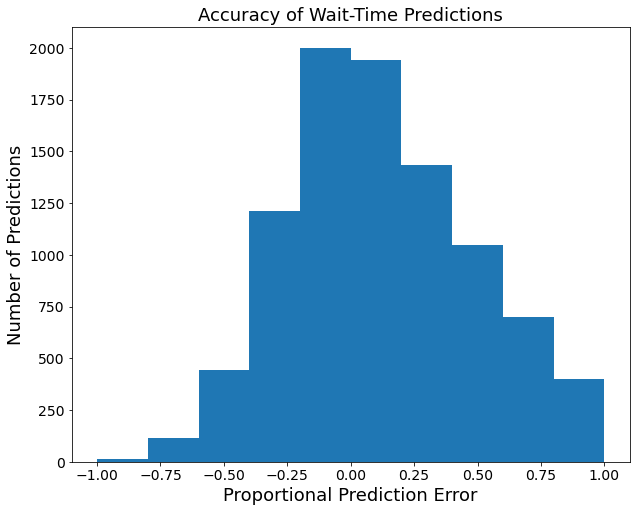

In [225]:
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize=(10, 8))
axes = plt.hist(prediction_errors, bins=np.linspace(-1, 1, 11))
plt.xlabel('Proportional Prediction Error', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of Predictions', fontsize=18)
plt.title('Accuracy of Wait-Time Predictions', fontsize=18)

### Evaluation of Wait-Time Model

As shown by the histogram above, a substantial number of predictions given by `wait_time_model` under- or overstate the actual waiting times by 50% or more. Possible avenues of improvement are as follows:

**Further cleanup of training data**. A substantial number of testing records state wait times of less than 30 days. This turnaround would seem unrealistically fast by USPTO standards. It would be useful to determine whether data-quality issues are skewing the training data.

**Train separate models for different event types**. As it currently stands, a variety of events are "lumped" into a single model. It may be useful to train two separate models: one for USPTO-triggered events, such as rulings on patentability; and a second for applicant-triggered events, such as legal arguments submitted to the USPTO. Because former have legally mandated response deadlines while the latter do not, it would seem reasonable to presume the respective turnaround times for those types of events differ significantly.

**Account for patent attorney identity.** For most types of USPTO rulings, an applicant can choose to extend the response deadline by paying a fee. Certain patent attorneys may be more likely to seek such extensions than others. Taking the identity of the attorney into account may reduce prediction errors by accounting for variations in turnaround times based on idiosyncratic attorney preferences. Attorney identities are available in the research datasets, but they were omitted from the model to save time.

## Next-Event Model

The `next_event_model` shown below predicts, given an examination event in a patent application, how soon the next examination event can be expected to occur. To avoid excessive training times, the training dataset is restricted to 10,000 events.

In [226]:
next_event_model = Pipeline([
    ('p1', ColumnTransformer([
            ('c1', OneHotEncoder(handle_unknown='ignore'), ['event_code']),
            ('c2', OneHotEncoder(handle_unknown='ignore'), ['examiner_art_unit']),
            ('c3', OneHotEncoder(handle_unknown='ignore'), ['examiner_full_name']),
            ('c4', TfidfVectorizer(stop_words=stop_words), 'invention_title'),
            ('c5', 'passthrough', ['pendency_time'])
    ])),
    ('p2', RandomForestClassifier())
])

### Training Next-Event Model

In [227]:
training_features, training_labels = get_features_and_labels(training_event_data, 'next_event_code')

In [228]:
training_features.head()

,event_code,pendency_time,examiner_art_unit,invention_title,examiner_full_name
0,CTRS,113,1616.0,Compositions and Methods for Treating Microorg...,"LIU, SUE XU"
5,CTNF,576,3771.0,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A"
6,CTFR,798,3771.0,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A"
7,CTNF,1086,3771.0,HAEMOSTAT APPLICATION,"SIMPSON, SARAH A"
15,CTNF,431,2877.0,COMPACT SPECTROMETER FOR TWO-DIMENSIONAL SAMPLING,"DECENZO, SHAWN H"


In [229]:
training_labels.head()

0     CTNF
5     CTFR
6     CTNF
7     CTFR
15    CTNF
Name: next_event_code, dtype: object

In [230]:
next_event_model.fit(training_features[:10_000], training_labels[:10_000])

Pipeline(steps=[('p1',
                 ColumnTransformer(transformers=[('c1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['event_code']),
                                                 ('c2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['examiner_art_unit']),
                                                 ('c3',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['examiner_full_name']),
                                                 ('c4',
                                                  TfidfVectorizer(stop_words=['a',
                                                                              'an',
                                                                              'and',
                                                                              'apparatus',
                                                                              'as',
                                                                              'at',
                                                                              'based',
                                                                              'by',
                                                                              'comprising',
                                                                              'device',
                                                                              'for',
                                                                              'from',
                                                                              'having',
                                                                              'in',
                                                                              'method',
                                                                              'methods',
                                                                              'of',
                                                                              'on',
                                                                              'or',
                                                                              'same',
                                                                              'system',
                                                                              'systems',
                                                                              'the',
                                                                              'thereof',
                                                                              'to',
                                                                              'use',
                                                                              'using',
                                                                              'with']),
                                                  'invention_title'),
                                                 ('c5', 'passthrough',
                                                  ['pendency_time'])])),
                ('p2', RandomForestClassifier())])

### Testing Next-Event Model

In [231]:
testing_features, testing_labels = get_features_and_labels(testing_event_data, 'next_event_code')

In [232]:
testing_features

,event_code,pendency_time,examiner_art_unit,invention_title,examiner_full_name
0,CTNF,368,2116.0,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY"
1,CTNF,421,2116.0,CONTROL OF A THERMAL CYCLIC PROCESS,"TRAN, VINCENT HUY"
9,CTNF,323,2886.0,METHOD FOR MONITORING LINEAR DIMENSIONS OF THR...,"AMARA, MOHAMED K"
11,CTRS,658,1782.0,"BLACK MATRIX, METHOD FOR MANUFACTURING THE SAM...","HON, SOW FUN"
12,CTNF,716,1782.0,"BLACK MATRIX, METHOD FOR MANUFACTURING THE SAM...","HON, SOW FUN"
...,...,...,...,...,...
655628,CTNF,573,3667.0,USED CAR GRADE DIAGNOSTIC SYSTEM,"CROMER, ANDREW J"
655629,CTFR,730,3667.0,USED CAR GRADE DIAGNOSTIC SYSTEM,"CROMER, ANDREW J"
655631,CTRS,676,3772.0,GRIPPING ELEMENT FLOSS,"KENNEDY, SHARON E"
655633,ABNX,67,1712.0,SURFACING SYSTEM FOR STEEL PLATE,"EMPIE, NATHAN H"


In [233]:
testing_labels

0         CTNF
1         A.NA
9         A.NA
11        CTNF
12        CTFR
          ... 
655628    CTFR
655629    CTNF
655631    CTNF
655633    CTRS
655637    CTFR
Name: next_event_code, Length: 307213, dtype: object

In [234]:
next_event_model.score(testing_features[:10_000], testing_labels[:10_000])

0.8458

In [235]:
predictions = next_event_model.predict(testing_features[:10_000])
predictions_vs_labels = tuple(zip(predictions, testing_labels[:10_000]))
ctnf_predictions = tuple(filter(lambda x: x[0] == 'CTNF', predictions_vs_labels))
ctfr_predictions = tuple(filter(lambda x: x[0] == 'CTFR', predictions_vs_labels))
cnoa_predictions = tuple(filter(lambda x: x[0] == 'CNOA', predictions_vs_labels))
ctnf_actual = tuple(filter(lambda x: x[1] == 'CTNF', predictions_vs_labels))
ctfr_actual = tuple(filter(lambda x: x[1] == 'CTFR', predictions_vs_labels))
cnoa_actual = tuple(filter(lambda x: x[1] == 'CNOA', predictions_vs_labels))

### Evaluation of Next-Event Model

Across all event codes, the `next_event_model` predicts the type of the next event correctly approximately 85% of the time. The model's performance, however, varies significantly according to the specific type of event being predicted. For brevity, the analysis below is limited to analyzing the model's performance for `CTNF`, `CTFR`, and `CNOA` events, which are the most important types of rulings made by the USPTO.

**Good performance for `CTNF` and `CTFR` events.** As shown Fig. 1 below, the model performs well in predicting `CTNF` and `CTFR` events, which are routine rulings of non-patentability and the most common types of ruling in patents. When a model predicts that an event will be of type `CTNF` or `CTFR`, the chances are 80% or higher that the actual event will be of that type. As shown in Fig. 2 below, the model is good at "capturing" `CTNF` and `CTFR` events. Approximately 80% of all `CTNF` events that actually occur are predicted in advance by the model. Likewise, the model successfully predicts nearly all actual `CTFR` events in advance. For `CTNF` and `CTFR` events, a user of the model can be reasonably confident that "false-positive" predictions (i.e., predicted `CTNF` and `CTFR` events that never actually occur) and  "false-negative" predictions (i.e., unpredicted `CTNF` and `CTFR` events) are limited.

**Worse performance for `CNOA` events.** The model's performance is substantially worse for `CNOA` events, which are rulings of patentability. Fig. 1 shows that given a prediction of a `CNOA` event, there is only a ~60% probability that the event will "come true." The model seems especially bad at "capturing" `CNOA` events. As shown in Fig. 2, the model predicts only 10% of the `CNOA` events that actually occur. With respect to `CNOA` events, the model has a "false-positive" rate of nearly 40% and a "false-negative" rate of nearly 90%. Possible causes of the poor performance for `CNOA` events are as follows:

1. **Poor data quality.** As a general matter, the research datasets seem rather spotting in cataloging "end-of-examination" events, such as a rulings of patentability or notices concerning abandoned applications. These inherent data-quality issues may be exacerbated by additional sources of inconsistency, such as the use of multiple event-type codes to describe a single underlying event type. Additional data cleanup may resolve some of these issues.

2. **Create separate models for different event types.** It may be useful to create separate models according to the event code of the input event. USPTO rules constrain what types of events can occur consecutively. A `CNOA` event (i.e., a notice of allowance), for example, can never directly follow a `CTNF` event or a `CTFR` event (i.e., a ruling of non-patentability); the applicant must make at least one intermediary filing to convince the USPTO that the earlier rejection event was unwarranted. These kinds of rulings are currently not taken into account; doing so could dramatically improve the accuracy of predicting `CNOA` events.

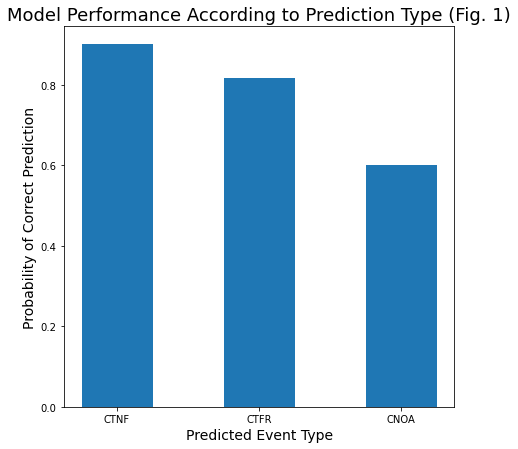

In [237]:
data = {
    'CTNF': len(tuple(filter(lambda x: x[0] == x[1], ctnf_predictions))) / len(ctnf_predictions),
    'CTFR': len(tuple(filter(lambda x: x[0] == x[1], ctfr_predictions))) / len(ctfr_predictions),
    'CNOA': len(tuple(filter(lambda x: x[0] == x[1], cnoa_predictions))) / len(cnoa_predictions)
}
event_types = list(data.keys())
accuracy = list(data.values())
  
fig = plt.figure(figsize = (7, 7))
 
# creating the bar plot
plt.bar(event_types, accuracy, width=0.5)
 
plt.xlabel("Predicted Event Type", fontsize=14)
plt.ylabel("Probability of Correct Prediction", fontsize=14)
plt.title("Model Performance According to Prediction Type (Fig. 1)", fontsize=18)
plt.show()

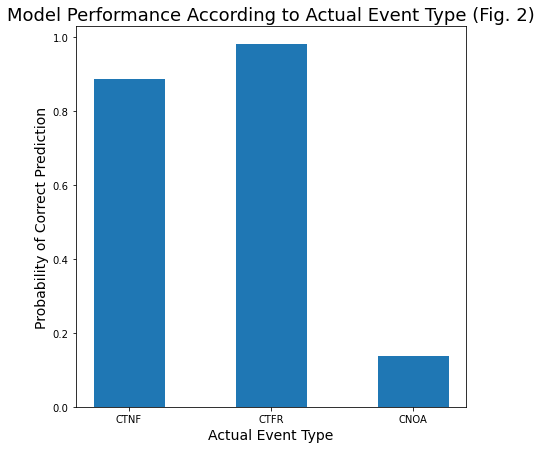

In [238]:
data = {
    'CTNF': len(tuple(filter(lambda x: x[0] == x[1], ctnf_actual))) / len(ctnf_actual),
    'CTFR': len(tuple(filter(lambda x: x[0] == x[1], ctfr_actual))) / len(ctfr_actual),
    'CNOA': len(tuple(filter(lambda x: x[0] == x[1], cnoa_actual))) / len(cnoa_actual)
}
event_types = list(data.keys())
accuracy = list(data.values())
  
fig = plt.figure(figsize = (7, 7))
 
# creating the bar plot
plt.bar(event_types, accuracy, width=0.5)
 
plt.xlabel("Actual Event Type", fontsize=14)
plt.ylabel("Probability of Correct Prediction", fontsize=14)
plt.title("Model Performance According to Actual Event Type (Fig. 2)", fontsize=18)
plt.show()